# Projekt 1
#### Mateusz Grzyb, Bartłomiej Eljasiak

## Wczytanie bibliotek

In [439]:
import random
import numpy as np
import pandas as pd

from scipy.stats import uniform
from scipy.stats import expon
from scipy.stats import randint

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics.scorer import make_scorer

from sklearn.model_selection import RandomizedSearchCV

from scipy import interp
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import matthews_corrcoef

from sklearn.metrics import plot_confusion_matrix

## Przygotowanie danych

Bazując na wynikach, z poprzednich etapów projektu, surowe dane obrobię w następujący sposób:

* Wczytam surowe dane,

* wykonam rzutowanie str na bool,

* tym razem zostawię kolumny '*_measured', będą informowały o miejsach imputacji,

* poprawię jedną, nierealną obserwację zmiennej 'age',

* usunę kolumny 'TBG' i 'TBG_measured', nie zawierają one żadnej informacji,

* usunę zmienną 'referral_source', której wątpliwą jakość omówiliśmy na etapie drugim,

* imputuję zmienną 'sex' w sposób losowy, z prawdopodobieństwami odpowiadającymi proporcjom klas.


In [440]:
raw_data=pd.read_csv('sick.csv')

# kopia surowych danych
data=raw_data.copy()

In [441]:
# sex (F == 1, M == 0)
data.loc[~data['sex'].isnull(), 'sex']=(data.loc[:, 'sex']=='F').astype(int)

# Class (Sick == 1, negative == 0)
data.loc[~data['Class'].isnull(), 'Class']=(data.loc[:, 'Class']=='sick').astype(int)

# pozostałe zmienne (t == 1, f == 0)
variables=set(list(data.columns))-set(['age', 'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG', 'referral_source', 'Class']) 

for variable in variables:
    data.loc[~data[variable].isnull(), variable]=(data.loc[:, variable]=='t').astype(int)

In [442]:
# najdluzej zyjacy czlowiek zyl 122 lata (a tutaj jeden ma 455...)
data.loc[data.age==455, 'age']=45

In [443]:
# zmienne 'TBG_measured', 'TBG' i 'referral_source' odpadaja
data=data.drop(['TBG_measured', 'TBG', 'referral_source'], axis=1)

In [444]:
# imputacja zmiennej 'sex'
random.seed=1
data.loc[data['sex'].isnull(), 'sex']=random.choices(population=[1,0], weights=[0.67, 0.33], k=1)[0]

In [445]:
# podglad danych
data

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,Class
0,41.0,1,0,0,0,0,0,0,0,0,...,1.30,1,2.5,1,125.0,1,1.14,1,109.0,0
1,23.0,1,0,0,0,0,0,0,0,0,...,4.10,1,2.0,1,102.0,0,NaN,0,NaN,0
2,46.0,0,0,0,0,0,0,0,0,0,...,0.98,0,NaN,1,109.0,1,0.91,1,120.0,0
3,70.0,1,1,0,0,0,0,0,0,0,...,0.16,1,1.9,1,175.0,0,NaN,0,NaN,0
4,70.0,1,0,0,0,0,0,0,0,0,...,0.72,1,1.2,1,61.0,1,0.87,1,70.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,1,0,0,0,0,0,0,0,0,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
3768,68.0,1,0,0,0,0,0,0,0,0,...,1.00,1,2.1,1,124.0,1,1.08,1,114.0,0
3769,74.0,1,0,0,0,0,0,0,0,0,...,5.10,1,1.8,1,112.0,1,1.07,1,105.0,0
3770,72.0,0,0,0,0,0,0,0,0,0,...,0.70,1,2.0,1,82.0,1,0.94,1,87.0,0


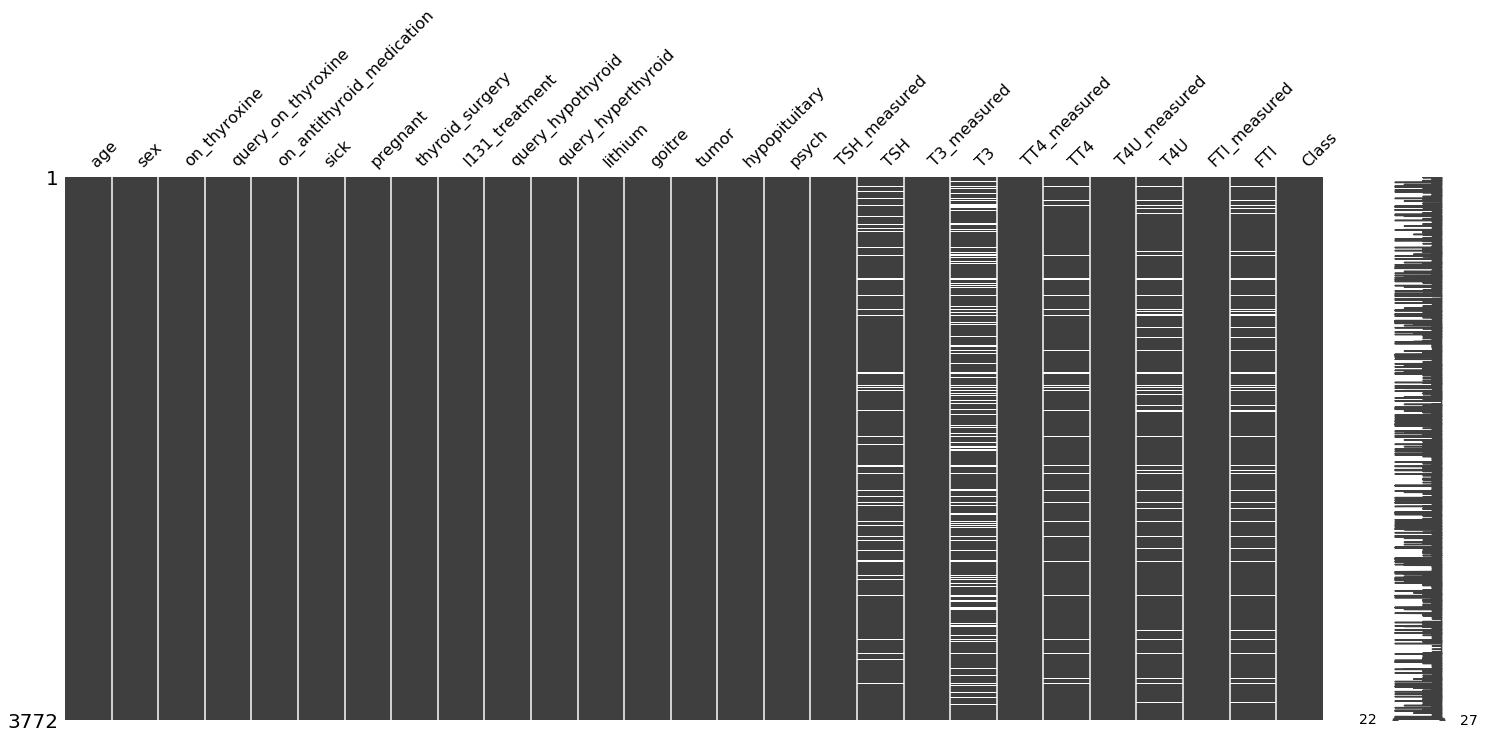

In [446]:
# podglad brakow
msno.matrix(data);

In [447]:
# dokonam jeszcze podzialu na zbior treningowy i testowy
X=data.drop('Class', axis=1)
y=data.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

## Przygotowanie modelu i metryki


Modelem, którym posłużę się w tej części projektu, jest XGBoost z imputacją mediany. Wybrałem go, ponieważ osiągnął on najlepsze wyniki w poprzedniej części projektu i jest szybki.

In [448]:
xgb=XGBClassifier(n_jobs=-1)
mi=SimpleImputer(strategy='median')
# pipeline zapewnia brak przecieku danych przy imputacji
classifier=make_pipeline(mi, xgb)

Funkcja RandomizedSearchCV pozwala na przekazanie metryki, za pomocą której będzie ona oceniać jakość wartości hiperparametrów. Chciałbym z tej możliwości skorzystać i napisać własną metrykę, bazując na tym artykule naukowym: https://www.sciencedirect.com/science/article/abs/pii/S0957417420302153?via%3Dihub (artykuł został udostępniony nam w całośći przez dr inż. Annę Wróblewską).

Zaproponowana w tym artykule metryka nazywa się Weighted TPR-TNR i wyraża następującym wzorem:

$$\text{Weighted TPR-TNR}=(TPR\cdot\frac{N}{P+N})+(TNR\cdot\frac{P}{P+N})$$

Jej wartość zależy zatem od proporcji klas zmiennej celu w zbiorze testowym. Autor artykułu twierdzi, że miara ta jest sczególnie użyteczna w przypadku zbiorów mocno niezbalansowanych (czyli dokładnie takich, jak nasz), a przeprowadzone przez niego eksperymenty dowodzą, że dużo częściej jest ona zgodna z ekspertyzą (w kontekście oceny działania różnych klasyfikatorów na danym zbiorze danych), niż metody takie jak TOPSIS czy GRA, biorące pod uwagę wiele metryk prostych.

In [449]:
def my_score_func(y_true, y_pred):
    
    P=sum(y_true)
    N=len(y_true)-P
    TN, FP, FN, TP=confusion_matrix(y_true, y_pred).ravel()
                
    w1=N/(P+N)
    w2=P/(P+N)
    TPR=TP/(TP+FN)
    TNR=TN/(TN+FP)
    
    score=TPR*w1+TNR*w2
    
    return score

In [450]:
# powinno wyjsc 1 (idealna predykcja)
my_score_func([1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

1.0

In [451]:
# powinno wyjsc 0 (przeciwienstwo idealnej predykcji)
my_score_func([0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

0.0

In [452]:
# powinno miec mniejszy wplyw na wynik (falszywy alaram)
my_score_func([1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 1])

0.9750000000000001

In [453]:
# powinno miec wiekszy wplyw na wynik (przeoczono chorobe)
my_score_func([1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

0.6000000000000001

## Strojenie hiperparametrów

Posłużę się funkcją RandomizedSearchCV.

In [454]:
# https://xgboost.readthedocs.io/en/latest/parameter.html
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

# domyslnie 'gbtree'
# "...I’ll consider only tree booster here because it always outperforms the linear booster and thus the later is rarely used."
booster=['gbtree']

# domyslnie 0.3
# musi byc z zakresu [0, 1]
# "Typical final values to be used are 0.01-0.2."
learning_rate=uniform(loc=0.01, scale=0.49)

# domyslnie 1
# musi byc z zakresu [1, ∞]
min_child_weight=randint(low=1, high=10)

# domyslnie 6
# musi byc z zakresu [1, ∞]
# "Beware that XGBoost aggressively consumes memory when training a deep tree."
max_depth=randint(low=1, high=10)

# domyslnie 0
# https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6
# "Gamma values around 20 are extremely high."
# scale=1/lambda
min_split_loss=uniform(loc=0, scale=20)
# lub
# min_split_loss=expon(scale=1/0.2)
# mozna podejrzec, P(X<20)~=0.98168
# r=min_split_loss.rvs(size=1000)
# sorted(r)

# domyslnie 0
# "Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced."
# "This is generally not used but you can explore further if you wish."
# "Set it to value of 1-10 might help control the update."
max_delta_step=uniform(loc=0, scale=10)

# domyslnie 1
# musi byc z zakresu (0, 1]
# "Typical values are 0.5-1."
subsample=uniform(loc=0.1, scale=0.9)

# domyslnie 1
# musi byc z zakresu (0, 1]
# "Typical values are 0.5-1"
colsample_bytree=uniform(loc=0.1, scale=0.9)

# domyslnie 1
# "I don’t use this often because subsample and colsample_bytree will do the job for you. but you can explore further if you feel so."
colsample_bylevel=[1]

# domyslnie 1
# "This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting."
reg_lambda=uniform(loc=0, scale=3)

# domyslnie 0
# "Can be used in case of very high dimensionality so that the algorithm runs faster when implemented."
reg_alpha=uniform(loc=0, scale=3)

# domyslnie 1
# "A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence."
scale_pos_weight=uniform(loc=0, scale=3)

# domyslnie 100
n_estimators=randint(50, 150)

params={
        'xgbclassifier__booster': booster, 
        'xgbclassifier__learning_rate': learning_rate,
        'xgbclassifier__min_child_weight': min_child_weight, 
        'xgbclassifier__max_depth': max_depth,
        'xgbclassifier__min_split_loss': min_split_loss, 
        'xgbclassifier__max_delta_step': max_delta_step, 
        'xgbclassifier__subsample': subsample, 
        'xgbclassifier__colsample_bytree': colsample_bytree, 
        'xgbclassifier__colsample_bylevel': colsample_bylevel, 
        'xgbclassifier__reg_lambda': reg_lambda, 
        'xgbclassifier__reg_alpha': reg_alpha, 
        'xgbclassifier__scale_pos_weight': scale_pos_weight,
        'xgbclassifier__n_estimators': n_estimators
}

random=RandomizedSearchCV(estimator=classifier, param_distributions=params, scoring=my_scorer, n_iter=1000, cv=5, n_jobs=-1, verbose=True)

In [455]:
random_result=random.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.3min finished


Udało się zauważalnie poprawić model, czego dowodem są następujące wyniki.

In [456]:
# sprawdzmy wynik najlepszego modelu
print('Weighted TPR-TNR for best tuned model: '+str(round(random_result.best_score_, 3)))

Weighted TPR-TNR for best tuned model: 0.913


In [457]:
# dla porownania wyniki przy domyslnych parametrach
classifier.fit(X_train, y_train)
print('Weighted TPR-TNR for default model: '+str(round(my_scorer(classifier, X_test, y_test), 3)))

Weighted TPR-TNR for default model: 0.856


Sprawdźmy jakie parametry modelu dobrał algorytm.

In [458]:
# parametry najlepszego klasyfikatora
random_result.best_estimator_.named_steps.xgbclassifier.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.22842240142848716,
 'gamma': 7.89431429,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.28344886280469794,
 'max_delta_step': 5.630460927948212,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 97,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 1.6980777560349871,
 'reg_lambda': 1.3687854964496986,
 'scale_pos_weight': 2.9034579858618503,
 'subsample': 0.9189542915429992,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'min_split_loss': 7.894314353844654}

Wspomniany wcześniej artykuł chwali także miarę "Matthews correlation coefficient (MCC)" przy ocenie klasyfikatorów na zbiorach niezbalansowanych. Jest ona już zaimplementowana w scikit-learn.

In [459]:
bm=random_result.best_estimator_
print('Weighted MCC for best tuned model: '+str(round(matthews_corrcoef(bm.predict(X_test), y_test), 3)))

Weighted MCC for best tuned model: 0.845


In [460]:
classifier.fit(X_train, y_train)
print('Weighted MCC for default model: '+str(round(matthews_corrcoef(classifier.predict(X_test), y_test), 3)))

Weighted MCC for default model: 0.819


Zawsze warto również spojrzeć na Confusion Matrix.

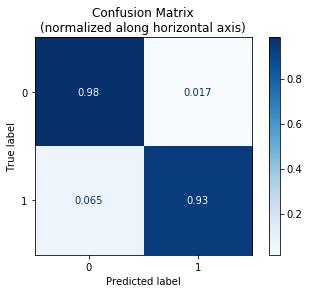

In [461]:
disp=plot_confusion_matrix(bm, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title('Confusion Matrix\n(normalized along horizontal axis)');

Wyniki są bardzo dobre. Model tylko w 1.7% przypadków fałszywie poinformował o chorobie i jednocześnie wykrył chorobę w 93% przypadków.
Model oczywiście nigdy wcześniej nie "widział" tych obserwacji, ponieważ funkcja RandomizedSearchCV została wywołana na zbiorze treningowym, nie ma więc mowy o przecieku danych.

## Feature Importance

Artykuł na temat Feature Importance w algorytmie XGBoost: https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

## Weight
"The **weight** is the percentage representing the relative number of times a particular feature occurs in the trees of the model."

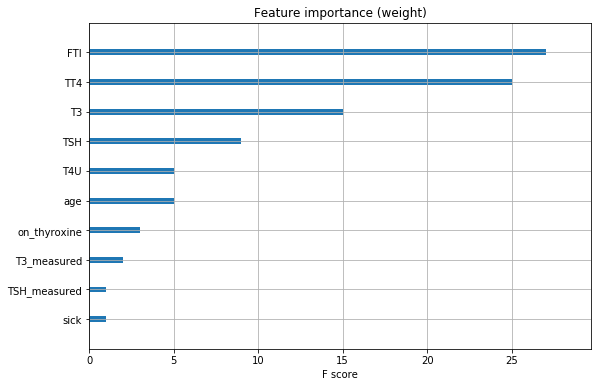

In [462]:
from xgboost import plot_importance
bm.named_steps.xgbclassifier.get_booster().feature_names=list(X.columns)
fig, ax=plt.subplots(figsize=(9,6))  
plot_importance(bm.named_steps.xgbclassifier, ylabel=None, importance_type='weight', title='Feature importance (weight)', show_values=False, ax=ax);

### Gain
"A higher **gain** value when compared to another feature implies it is more important for generating a prediction."

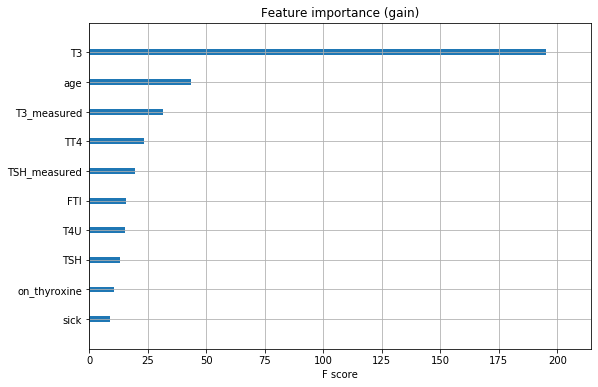

In [463]:
fig, ax=plt.subplots(figsize=(9,6))  
plot_importance(bm.named_steps.xgbclassifier, ylabel=None, importance_type='gain', title='Feature importance (gain)', show_values=False, ax=ax);

### Coverage

"The **Coverage** metric means the relative number of observations related to this feature."

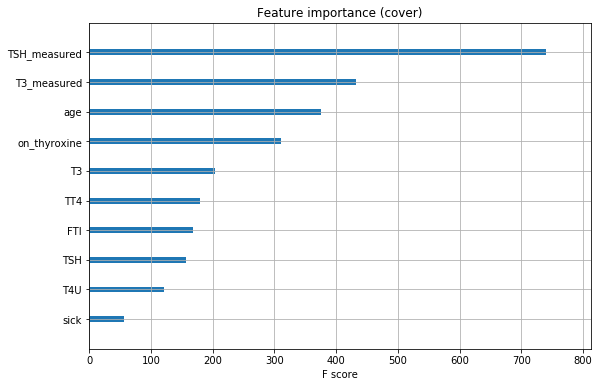

In [464]:
fig, ax=plt.subplots(figsize=(9,6))  
plot_importance(bm.named_steps.xgbclassifier, ylabel=None, importance_type='cover', title='Feature importance (cover)', show_values=False, ax=ax);

<div align="center">
    "The gain is the most relevant attribute to interpret the relative importance of each feature."
</div>